In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [2]:
resp = requests.get('https://data.ct.gov/resource/rf3k-f8fg.json')
txt = resp.json()

In [3]:
dat_orig = pd.DataFrame(txt)

In [4]:
dat = dat_orig[dat_orig['state']=='CONNECTICUT'].copy()

dat = dat[['date', 'totalcases', 'totaldeaths', 'cases_age0_9', 'covid_19_pcr_tests_reported']]

cols = dat.columns.drop('date')

dat[cols] = dat[cols].apply(pd.to_numeric, errors='coerce')

dat['date'] = dat['date'].apply(pd.to_datetime).dt.floor("D")

In [5]:
sort_dat = dat.sort_values(by=['date'], inplace=False, ascending=True).copy()

In [6]:
sort_dat['daily_new_cases'] = sort_dat['totalcases'].diff()
sort_dat['daily_new_deaths'] = sort_dat['totaldeaths'].diff()
sort_dat['daily_new_child_cases'] = sort_dat['cases_age0_9'].diff()
sort_dat['daily_new_tests'] = sort_dat['covid_19_pcr_tests_reported'].diff()

In [7]:
# sort_dat['new_cases_roll3'] = sort_dat['daily_new_cases'].rolling(3).mean().round()
sort_dat['rolling_new_cases'] = sort_dat['daily_new_cases'].rolling(7).mean().round()
# sort_dat['new__child_cases_roll3'] = sort_dat['daily_new_child_cases'].rolling(3).mean().round()
sort_dat['rolling_new__child_cases'] = sort_dat['daily_new_child_cases'].rolling(7).mean().round()
# sort_dat['new_deaths_roll3'] = sort_dat['daily_new_deaths'].rolling(3).mean().round()
sort_dat['rolling_new_deaths'] = sort_dat['daily_new_deaths'].rolling(7).mean().round()

In [8]:
#Add positive test rate
sort_dat['positive_test_rate'] = sort_dat['daily_new_cases']/sort_dat['daily_new_tests']
sort_dat['rolling_test_rate'] = sort_dat['positive_test_rate'].rolling(7).mean().round(4)

In [9]:
# Modeling
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

ignore_first_obs = 7
test_obs = 10
forecast_len = 7

train = sort_dat.set_index('date').iloc[ignore_first_obs:-test_obs, :]
test = sort_dat.set_index('date').iloc[-test_obs:, :]
# train.index = pd.to_datetime(train.index)
# test.index = pd.to_datetime(test.index)
# pred = test.copy()

In [33]:
from datetime import timedelta, date 

forecast_range = pd.DataFrame(index = pd.date_range(sort_dat.iloc[0]['date'],
                                   sort_dat.iloc[-1]['date'] + timedelta(days=forecast_len), 
                                   freq='D'))

extended_dat = pd.merge(forecast_range, sort_dat.set_index('date'), left_index = True, right_index = True, how = 'left').copy()

In [11]:
model_test_rate = ExponentialSmoothing(np.asarray(train['positive_test_rate'].clip(0.0000000000001)), trend='multiplicative', seasonal=None)

#Not sure if this is needed...broke the code
# model._index = pd.to_datetime(train.index)

test_rate_fit = model_test_rate.fit()
test_rate_pred = test_rate_fit.forecast(test_obs + forecast_len)

# Dampned Trend Fit
# model2 = ExponentialSmoothing(np.asarray(train['positive_test_rate']), trend='mul', seasonal=None, damped=True)
# fit2 = model2.fit()
# pred2 = fit2.forecast(10)

In [12]:
model_deaths = ExponentialSmoothing(np.asarray(train['daily_new_deaths'].clip(0.0000000000001)), trend='multiplicative', seasonal=None)

test_deaths_fit = model_deaths.fit()
test_deaths_pred = test_deaths_fit.forecast(test_obs + forecast_len)

In [13]:
model_cases = ExponentialSmoothing(np.asarray(train['daily_new_cases'].clip(0.0000000000001)), trend='multiplicative', seasonal=None)

test_cases_fit = model_cases.fit()
test_cases_pred = test_cases_fit.forecast(test_obs + forecast_len)

In [14]:
model_child_cases = ExponentialSmoothing(np.asarray(train['daily_new_child_cases'].clip(0.0000000000001)), trend='multiplicative', seasonal=None)

test_child_cases_fit = model_child_cases.fit()
test_child_cases_pred = test_child_cases_fit.forecast(test_obs + forecast_len)

In [15]:
extended_dat['modeled_test_rate'] = np.append(np.append(np.repeat(np.nan, ignore_first_obs), 
                                                        test_rate_fit.fittedvalues.round(4)), 
                                              test_rate_pred.round(4)).tolist()

extended_dat['modeled_deaths'] = np.append(np.append(np.repeat(np.nan, ignore_first_obs), 
                                                        test_deaths_fit.fittedvalues.round(4)), 
                                              test_deaths_pred.round(4)).tolist()

extended_dat['modeled_cases'] = np.append(np.append(np.repeat(np.nan, ignore_first_obs), 
                                                        test_cases_fit.fittedvalues.round(4)), 
                                              test_cases_pred.round(4)).tolist()

extended_dat['modeled_child_cases'] = np.append(np.append(np.repeat(np.nan, ignore_first_obs), 
                                                        test_child_cases_fit.fittedvalues.round(4)), 
                                              test_child_cases_pred.round(4)).tolist()

extended_dat['date'] = extended_dat.index

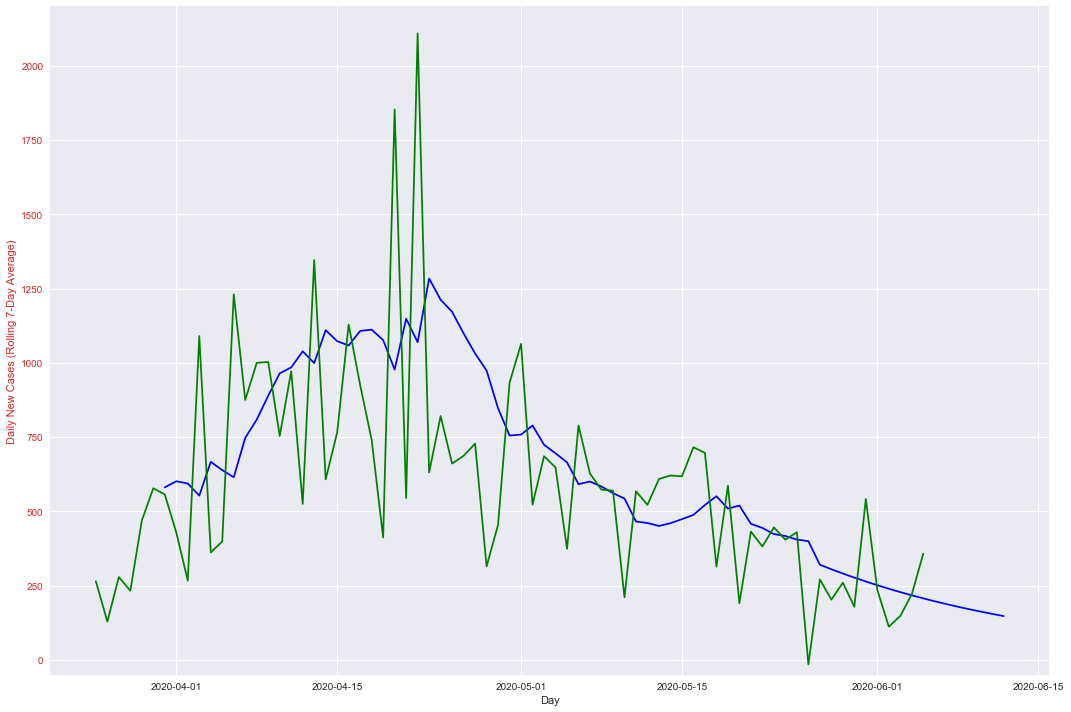

In [21]:

plt.style.use('seaborn')

fig, ax1 = plt.subplots(figsize=(15,10))

color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('Daily New Cases (Rolling 7-Day Average)', color=color)
# ax1.plot(extended_dat['date'], extended_dat['rolling_new_cases'], color=color)
ax1.plot(extended_dat['date'], extended_dat['modeled_cases'], color='blue')
ax1.plot(extended_dat['date'], extended_dat['daily_new_cases'], color='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-50, 2200])

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('Daily New Deaths (Rolling 7-Day Average)', color=color)
# ax2.plot(extended_dat['date'], extended_dat['rolling_new_deaths'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([0, 120])

fig.tight_layout()
plt.show()

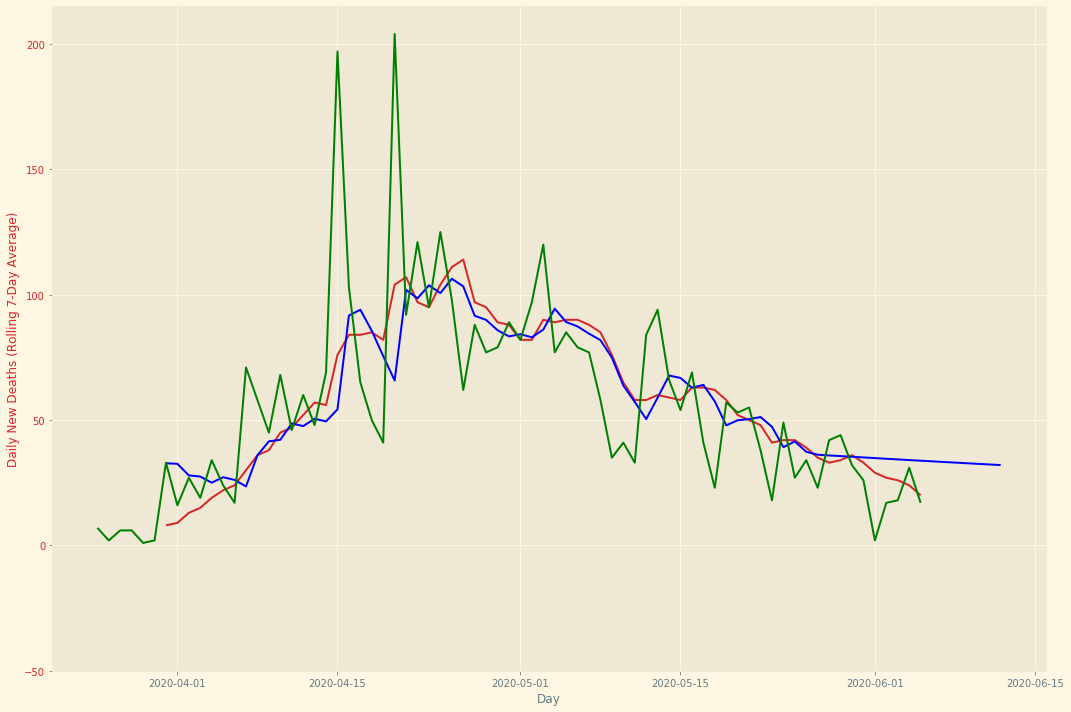

In [20]:
plt.style.use('seaborn')

fig, ax1 = plt.subplots(figsize=(15,10))

color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('Daily New Deaths (Rolling 7-Day Average)', color=color)
# ax1.plot(extended_dat['date'], extended_dat['rolling_new_deaths'], color=color)
ax1.plot(extended_dat['date'], extended_dat['modeled_deaths'], color='blue')
ax1.plot(extended_dat['date'], extended_dat['daily_new_deaths'], color='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-50, 215])

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('Daily New Deaths (Rolling 7-Day Average)', color=color)
# ax2.plot(extended_dat['date'], extended_dat['rolling_new_deaths'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([0, 120])

fig.tight_layout()
plt.show()

In [22]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

In [23]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/gmail.compose',
         'https://www.googleapis.com/auth/gmail.send']

# Gmail scopes: https://developers.google.com/identity/protocols/oauth2/scopes#gmail
# Sheets scopes: https://developers.google.com/identity/protocols/oauth2/scopes#sheets

def build_serv():
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    sheets = build('sheets', 'v4', credentials=creds)
    mail = build('gmail', 'v1', credentials=creds)
    service = {'sheets': sheets,
              'mail': mail}
    return(service)

service = build_serv()
mail_service = service['mail']
sheets_service = service['sheets']

In [24]:
def read_data(service, spreadsheet, sheet_range):
    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=spreadsheet, 
                                range=sheet_range).execute()
    values = result.get('values', [])
    return(values)

In [25]:
def send_data(service, dat, date_col, spreadsheet_id, sheet_range):
    send_dat = dat.copy()
    send_dat[date_col] = send_dat[date_col].dt.strftime('%Y-%m-%d')
    send_dat.fillna('', inplace=True)
    
    # How the input data should be interpreted.
    value_input_option = 'USER_ENTERED'  # USER_ENTERED to mimic Sheets entry, RAW to place data as-is

    # How the input data should be inserted.
    insert_data_option = 'OVERWRITE'  # not being used at the moment, function overwrites by default

    dfHeaders = send_dat.columns.values.tolist()
    dfHeadersArray = [dfHeaders]
    dfData = send_dat.values.tolist()

    value_range_body = {
            "majorDimension": "ROWS",
            "values": dfHeadersArray + dfData
        }

    request = service.spreadsheets().values().update(spreadsheetId=spreadsheet_id, 
                                                     range=sheet_range, 
#                                                      insertDataOption=insert_data_option,
                                                     valueInputOption=value_input_option, 
                                                     body=value_range_body)
    response = request.execute()

    return(response)

In [55]:
# Get Current Projection Data
mit = read_data(sheets_service, '1h8PgeXtEDaHQCmsFIcqDA3Hm_kVFRrR-jcEfVPfMwAI', 'projections')
mit = pd.DataFrame(mit)
mit_header = mit.iloc[0] #grab the first row for the header
mit = mit[1:] #take the data less the header row
mit.columns = mit_header
mit['Day'] = mit['Day'].apply(pd.to_datetime).dt.floor("D")


In [52]:
# Get Latest Projection Data
warnings.simplefilter('ignore', FutureWarning)

mit_new = pd.read_csv('https://raw.githubusercontent.com/COVIDAnalytics/DELPHI/master/predicted/Global.csv', error_bad_lines=False)
mit_new = mit_new[mit_new['Province']=='Connecticut']
mit_new['Day'] = mit_new['Day'].apply(pd.to_datetime).dt.floor("D")
mit_new = mit_new[mit_new['Day'] > date.today() + timedelta(days=1)]

In [59]:
# Join Projection Data
mit_old = mit[mit['Day'] < date.today() + timedelta(days=2)].copy()
mit_latest = mit_old.append(mit_new).copy()


In [ ]:
# Update Google Sheet with latest data
send_data(sheets_service, sort_dat, 'date', '1h8PgeXtEDaHQCmsFIcqDA3Hm_kVFRrR-jcEfVPfMwAI', 'data')
send_data(sheets_service, mit_latest, 'date', '1h8PgeXtEDaHQCmsFIcqDA3Hm_kVFRrR-jcEfVPfMwAI', 'data')


In [ ]:
# Load alerts from Google Sheet
def pull_alerts(service, spreadsheet_id, sheet_range):
    alerts = read_data(service, spreadsheet_id, sheet_range)
    alerts = pd.DataFrame(alerts)
    new_header = alerts.iloc[0] #grab the first row for the header
    alerts = alerts[1:] #take the data less the header row
    alerts.columns = new_header #set the header row as the df header
    return(alerts)

In [ ]:
alerts = pull_alerts(sheets_service, '1h8PgeXtEDaHQCmsFIcqDA3Hm_kVFRrR-jcEfVPfMwAI', 'alerts')

In [ ]:
# alerts

In [ ]:
latest_day = sort_dat.iloc[len(sort_dat)-1]

carriers = {'verizon':'@vtext.com',
            'xfinity':'@vtext.com', 
            'google_fi':'@msg.fi.google.com', 
            'tmobile':'@tmomail.net',
           'virgin':'@vmobl.com', 
           'att':'@txt.att.net',
           'sprint':'@messaging.sprintpcs.com',
           'boost':'@sms.myboostmobile.com',
           'metro':'@mymetropcs.com',
           'us_cellular':'@email.uscc.net',
           'cricket':'@mms.cricketwireless.net',
           'republic':'@text.republicwireless.com',
           'straight_talk':'@vtext.com'}

In [ ]:
from apiclient import errors
from httplib2 import Http
from email.mime.text import MIMEText
import base64
from google.oauth2 import service_account

def create_message(sender, to, subject, message_text):
    """Create a message for an email.
    Args:
    sender: Email address of the sender.
    to: Email address of the receiver.
    subject: The subject of the email message.
    message_text: The text of the email message.
    Returns:
    An object containing a base64url encoded email object.
    """
    message = MIMEText(message_text)
    message['to'] = to
    message['from'] = sender
    message['subject'] = subject
    return {'raw': base64.urlsafe_b64encode(message.as_string().encode()).decode()}

def send_message(service, user_id, message):
    """Send an email message.
    Args:
    service: Authorized Gmail API service instance.
    user_id: User's email address. The special value "me"
    can be used to indicate the authenticated user.
    message: Message to be sent.
    Returns:
    Sent Message.
    """
    try:
        message = (service.users().messages().send(userId=user_id, body=message)
                   .execute())
        print('Message Id: %s' % message['id'])
        return message
    except errors.HttpError as error:
        print('An error occurred: %s' % error)

In [ ]:
EMAIL_FROM = 'jcdrummr@gmail.com'

for row in alerts.itertuples():
    if latest_day[row.metric] <= float(row.threshold):
        EMAIL_TO = row.phone + carriers[row.carrier]
        EMAIL_SUBJECT = 'CT COVID-19 Alert System'
        EMAIL_CONTENT = row.metric + ' is now at ' + \
                        str(latest_day[row.metric]) + ', below your alert threshold of ' + \
                        str(row.threshold)
        # Call the Gmail API
        message = create_message(EMAIL_FROM, EMAIL_TO, EMAIL_SUBJECT, EMAIL_CONTENT)
        sent = send_message(mail_service,'me', message)

In [ ]:
# dat = dat_orig[dat_orig['state']=='CONNECTICUT'].copy()

# dat = dat[['date', 'cases', 'deaths', 'cases_age0_9']]

# cols = dat.columns.drop('date')

# dat[cols] = dat[cols].apply(pd.to_numeric, errors='coerce')

# dat['date'] = dat['date'].apply(pd.to_datetime)